# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input.

## System: NARX

Consider a system generating observations $y_k \in \mathbb{R}$ based on inputs $u_k \in \mathbb{R}$:

$$ y_k = \theta^{\top}\phi(u_k, x_k) + e_k \, ,$$

where $x_k \in \mathbb{R}^{D}$ is a vector of previous observations and $\theta$ are coefficients. The noise instances $e_k$ are assumed to be zero-mean Gaussian distributed with variance $\sigma^2$.

In [1]:
using Revise
using FFTW
using DSP
using ForwardDiff
using Optim
using RxInfer
using SpecialFunctions
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3, margin=20Plots.pt)

includet("../NARXAgents.jl"); using .NARXAgents
includet("../NARXsystem.jl"); using .NARXsystem

In [2]:
# Time
N = 256
fs = 50 # Hertz
Δt = 1/fs
tsteps = collect(range(0.0, step=Δt, length=N));

In [3]:
# Define system parameters
sys_mnoise_sd = 1e-3;
input_lims = (-1.,1.)

H = 3
# function sys_basis(x::AbstractVector) 
#     basis = [1.0]
#     for n in 1:length(x)
#         for d in 1:H
#             push!(basis, x[n].^d)
#         end
#     end
#     return basis
# end
# rbf(x, a=0.0, l=1.0) = exp(-(x-a)^2./l)
# sys_basis(x) = cat([1; [rbf(x, a=a) for a in range(-1, stop=1, length=H)]]...,dims=1)
sys_basis(x) = cat([1.0; [x.^d for d in 1:H]]...,dims=1)

M_in = 2
M_out = 2
M = size(sys_basis(zeros(M_out + 1 + M_in)),1);
# sys_coefficients = [0.0, 0.2, -1., -.8, -.01, -.01, -.01]
# sys_coefficients = [0.0; -cos.((1:M-1.)./(π))./2]

df = digitalfilter(Lowpass(1.2; fs=1/Δt), Butterworth(2))
sys_coefficients = [0.0; sys_basis([coefb(df)[2:end]; coefa(df)])[2:end]]./10

16-element Vector{Float64}:
  0.0
  0.0010258536732214293
  0.0005129268366107147
  0.1
 -0.17874325179564848
  0.08079495914209134
  1.052375758861899e-5
  2.6309393971547476e-6
  0.1
  0.3194915006248259
  0.06527825422772209
  1.0795835378376683e-7
  1.3494794222970854e-8
  0.1
 -0.5710694974275283
  0.05274153883195857

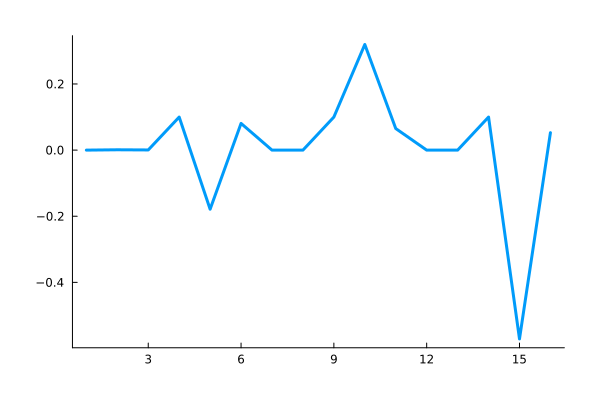

In [4]:
plot(sys_coefficients)

In [5]:
# Inputs
Ω  = rand(5)*10
controls = mean([sin.(ω.*tsteps) for ω in Ω]);
# controls = [0.0; 3*ones(N-1)]

256-element Vector{Float64}:
  0.0
  0.07800140767062017
  0.1543194123313402
  0.2273319864534507
  0.2955374684262855
  0.35760887635111893
  0.4124414368193549
  0.4591914861208982
  0.49730523931290327
  0.5265363194712358
  ⋮
 -0.04672606599897462
 -0.013179017460790355
  0.026482004138951097
  0.07128513642683845
  0.12003003714826574
  0.17133237591854703
  0.22367573560081738
  0.27546890014289527
  0.3251062930494855

In [6]:
# Outputs
system = NARXsys(sys_coefficients, sys_basis, sys_mnoise_sd, order_outputs=M_out, order_inputs=M_in, input_lims=input_lims)

outputs = zeros(N)
inputs = zeros(N)
for k in 1:N
    NARXsystem.update!(system, controls[k])
    outputs[k] = system.observation
    inputs[k] = system.input_buffer[1]
end

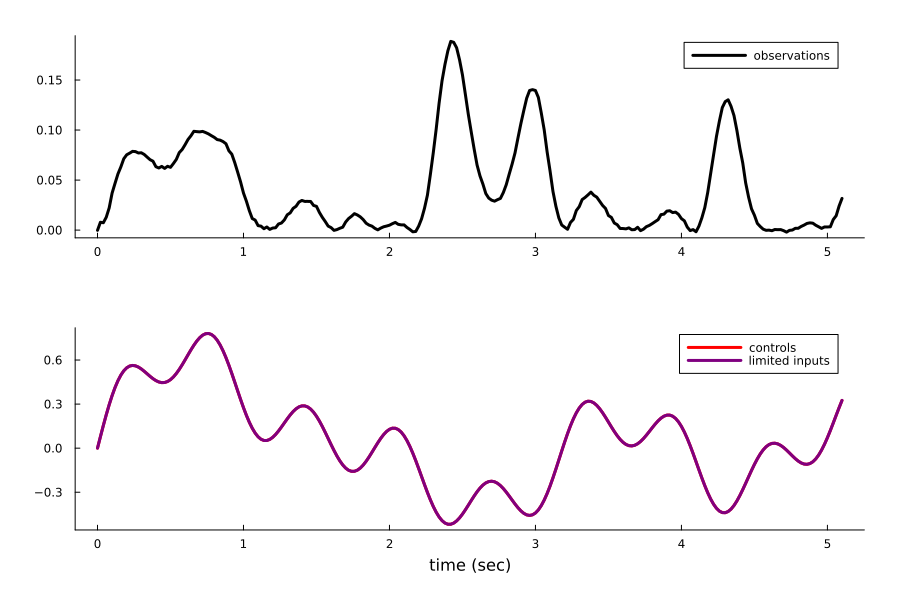

In [7]:
p101 = plot(tsteps, outputs, color="black", label="observations")
p102 = plot(tsteps, controls, color="red", label="controls", xlabel="time (sec)")
plot!(tsteps, inputs, color="purple", label="limited inputs", xlabel="time (sec)")
plot(p101, p102, layout=grid(2,1), size=(900,600))

## NARX parameter estimation

In [8]:
# Polynomial degree
H = 3

# Delay order
Ly = M_in
Lu = M_out

# Model order
M = size(pol(zeros(1+Ly+Lu), degree=H),1);

In [9]:
# Specify prior distributions
pτ0 = GammaShapeRate(1e2, 1e0)
pθ0 = MvNormalMeanCovariance(zeros(M), 1e2diagm(ones(M)))
goal = NormalMeanVariance(sqrt(2)/2, 1e-3)

agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H)

NARXAgent(FactorGraphModel(), Constraints:
  marginals form:
  messages form:
  factorisation:
    q(θ, τ) = q(θ)q(τ)
Options:
  warn = true
, [Inf], MvNormalMeanCovariance(
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [100.0 0.0 … 0.0 0.0; 0.0 100.0 … 0.0 0.0; … ; 0.0 0.0 … 100.0 0.0; 0.0 0.0 … 0.0 100.0]
)
, GammaShapeRate{Float64}(a=100.0, b=1.0), NormalMeanVariance{Float64}(μ=0.7071067811865476, v=0.001), 1, 10, 0.0, 2, 2, 3, 16, [0.0, 0.0], [0.0, 0.0, 0.0])

In [10]:
py = []
qθ = [pθ0]
qτ = [pτ0]
FE = zeros(10,N)

T = 10
@showprogress for k in 1:(N-T)
    
    # Make predictions
    push!(py, predictions(agent, inputs[k:k+T], time_horizon=T))
    
    # Update beliefs
    NARXAgents.update!(agent, outputs[k], inputs[k])
    push!(qθ, agent.qθ)
    push!(qτ, agent.qτ)
    
    # Evaluate
    FE[:,k] = agent.free_energy
end

Progress:   1%|▍                                        |  ETA: 0:25:54

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


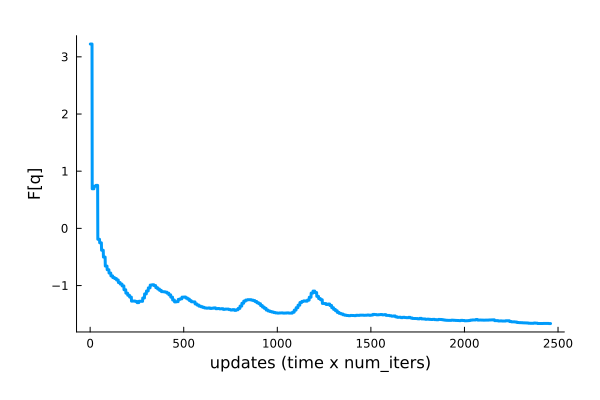

In [11]:
plot(reshape(FE[:,1:(N-T)], (10*(N-T),)), xlabel="updates (time x num_iters)", ylabel="F[q]")

In [12]:
vθ = cat( var.(qθ)...,dims=2)
mθ = cat(mean.(qθ)...,dims=2)

16×247 Matrix{Float64}:
 0.0  -0.000194226  -6.67314e-5    4.37972e-5   …  -1.18481e-5   1.14488e-6
 0.0   0.0          -0.000247679  -0.00991156       0.0100442    0.0116012
 0.0   0.0           0.0           0.000227713     -0.0686672   -0.0698984
 0.0   0.0           0.0994579     0.0962133        0.0961307    0.0967124
 0.0   0.0           0.0          -0.0914406       -0.170609    -0.171751
 0.0   0.0           0.0           0.0          …   0.0767026    0.0772239
 0.0   0.0           4.81105e-8   -7.24033e-5      -0.0470407   -0.0478974
 0.0   0.0           0.0          -4.42323e-8       0.00753038   0.00755594
 0.0   0.0           0.00775786   -0.00630174       0.159118     0.15781
 0.0   0.0           0.0          -0.00713249       0.17296      0.174888
 0.0   0.0           0.0           0.0          …   0.185363     0.184488
 0.0   0.0          -9.34527e-12  -5.70616e-7      -0.00321128  -0.00231855
 0.0   0.0           0.0           8.59194e-12      0.0219874    0.0231576
 0.

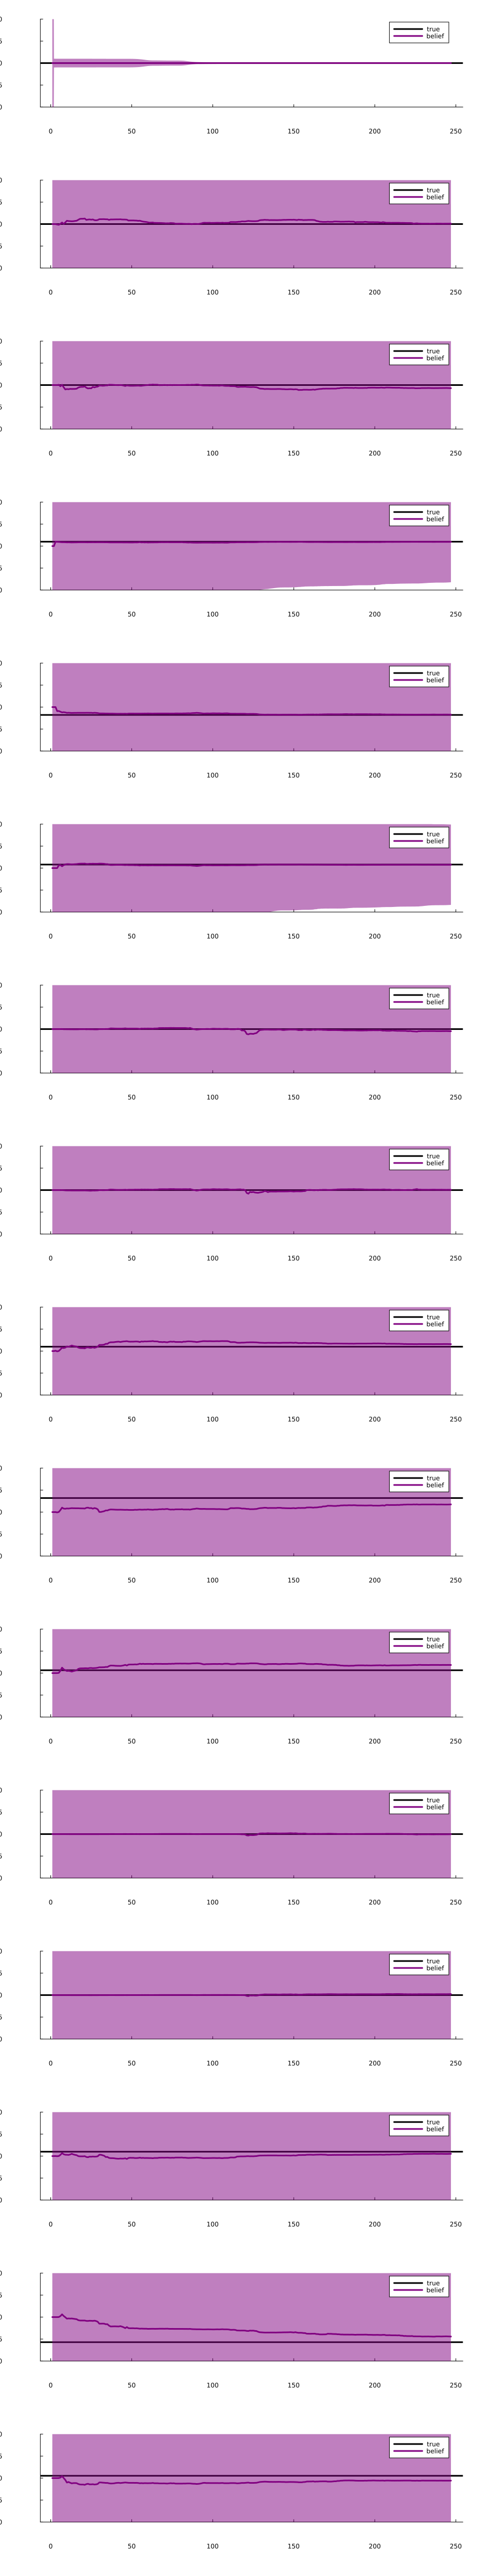

In [13]:
pw = []
for m in 1:M
    pwm = plot(ylims=(-1.,1.))
    
    hline!([sys_coefficients[m]], color="black", label="true")
    plot!(mθ[m,:], ribbon=sqrt.(vθ[m,:]), color="purple", label="belief", ylabel="θ_$m")
    
    push!(pw,pwm)
end
plot(pw..., layout=(M,1), size=(900,M*300))

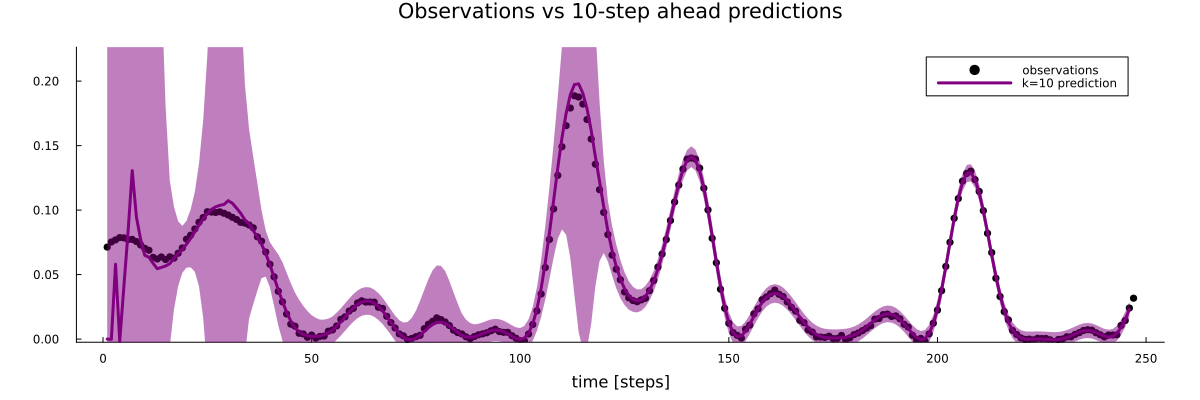

In [14]:
limsb = [minimum(outputs)*1.2, maximum(outputs)*1.2]
K = 10

p1 = plot(xlabel="time [steps]", title="Observations vs $K-step ahead predictions", ylims=limsb, size=(1200,400))
scatter!(outputs[K:end], color="black", label="observations")
plot!([py[k][1][K] for k in 1:(N-T)], ribbon=[py[k][2][K] for k in 1:(N-T)], color="purple", label="k=$K prediction")

## Experiments

In [15]:
# Length of trial
N = 100
tsteps = range(0.0, step=Δt, length=N)
T = 10

# Orders
H = 3
Ly = M_in
Lu = M_out
M = size(pol(zeros(1+Ly+Lu), degree=H),1);

# Set control properties
goal = NormalMeanVariance(sqrt(2)/2, 1e-4)
control_prior = 0.0
num_iters = 10
u_lims = (-1., 1.)
tlimit = 10

# Specify prior distributions
pτ0 = GammaShapeRate(1e2, 1e0)
pθ0 = MvNormalMeanCovariance(zeros(M), 1e2diagm(ones(M)))

MvNormalMeanCovariance(
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [100.0 0.0 … 0.0 0.0; 0.0 100.0 … 0.0 0.0; … ; 0.0 0.0 … 100.0 0.0; 0.0 0.0 … 0.0 100.0]
)


### Expected Free Energy minimization

In [16]:
# Start system
system = NARXsys(sys_coefficients, 
                 sys_basis,
                 sys_mnoise_sd, 
                 order_outputs=M_out, 
                 order_inputs=M_in)

# Start agent
agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  thorizon=T)

# Preallocate
y_EFE = zeros(N)
u_EFE = zeros(N+T)
pτ_EFE = [pτ0]
pθ_EFE = [pθ0]
py_EFE = []
FE_EFE = zeros(num_iters, N)
goals = [NormalMeanVariance(mean(goal), Inf) for t in 1:T]
gvars = 10 .^range(1, stop=-3, length=N)

@showprogress for k in 1:N
    
    # Act upon environment
    NARXsystem.update!(system, u_EFE[k])
    y_EFE[k] = system.observation
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_EFE[k], u_EFE[k])
    
    FE_EFE[:,k] = agent.free_energy
    push!(pθ_EFE, agent.qθ)
    push!(pτ_EFE, agent.qτ)
    
    # Move goal closer
    goal_k = NormalMeanVariance(mean(goal), gvars[k])
    update_goals!(goals, goal_k)
    agent.goals = goals
    
    # Optimal control
    policy = minimizeEFE(agent, goals, time_limit=tlimit, control_lims=u_lims)
    u_EFE[k+1:k+T] = policy
    
    # Store future predictions
    push!(py_EFE, predictions(agent, policy, time_horizon=T))
    
end

Progress:   2%|▉                                        |  ETA: 0:17:03

Progress:   3%|█▎                                       |  ETA: 0:12:36

Progress:   4%|█▋                                       |  ETA: 0:10:19

Progress:   5%|██                                       |  ETA: 0:09:22

Progress:   6%|██▌                                      |  ETA: 0:10:24

Progress:   7%|██▉                                      |  ETA: 0:08:52

Progress:   8%|███▎                                     |  ETA: 0:07:42

Progress:   9%|███▊                                     |  ETA: 0:06:47

Progress:  10%|████▏                                    |  ETA: 0:06:04

Progress:  11%|████▌                                    |  ETA: 0:05:28

Progress:  12%|████▉                                    |  ETA: 0:04:58

Progress:  13%|█████▍                                   |  ETA: 0:04:33

Progress:  14%|█████▊                                   |  ETA: 0:04:12

Progress:  15%|██████▏                                  |  ETA: 0:03:53

Progress:  16%|██████▌                                  |  ETA: 0:03:36

Progress:  17%|███████                                  |  ETA: 0:03:22

Progress:  18%|███████▍                                 |  ETA: 0:03:10

Progress:  19%|███████▊                                 |  ETA: 0:02:58

Progress:  20%|████████▎                                |  ETA: 0:02:48

Progress:  21%|████████▋                                |  ETA: 0:02:38

Progress:  22%|█████████                                |  ETA: 0:02:29

Progress:  24%|█████████▉                               |  ETA: 0:02:14

Progress:  25%|██████████▎                              |  ETA: 0:02:07

Progress:  26%|██████████▋                              |  ETA: 0:02:01

Progress:  27%|███████████▏                             |  ETA: 0:01:56

Progress:  28%|███████████▌                             |  ETA: 0:01:50

Progress:  29%|███████████▉                             |  ETA: 0:01:45

Progress:  30%|████████████▎                            |  ETA: 0:01:41

Progress:  31%|████████████▊                            |  ETA: 0:01:36

Progress:  32%|█████████████▏                           |  ETA: 0:01:32

Progress:  33%|█████████████▌                           |  ETA: 0:01:28

Progress:  35%|██████████████▍                          |  ETA: 0:01:21

Progress:  36%|██████████████▊                          |  ETA: 0:01:18

Progress:  37%|███████████████▏                         |  ETA: 0:01:15

Progress:  38%|███████████████▋                         |  ETA: 0:01:12

Progress:  39%|████████████████                         |  ETA: 0:01:09

Progress:  40%|████████████████▍                        |  ETA: 0:01:06

Progress:  41%|████████████████▊                        |  ETA: 0:01:04

Progress:  42%|█████████████████▎                       |  ETA: 0:01:01

Progress:  44%|██████████████████                       |  ETA: 0:00:57

Progress:  45%|██████████████████▌                      |  ETA: 0:00:55

Progress:  47%|███████████████████▎                     |  ETA: 0:00:51

Progress:  48%|███████████████████▋                     |  ETA: 0:00:49

Progress:  49%|████████████████████▏                    |  ETA: 0:00:47

Progress:  50%|████████████████████▌                    |  ETA: 0:00:45

Progress:  52%|█████████████████████▍                   |  ETA: 0:00:42

Progress:  53%|█████████████████████▊                   |  ETA: 0:00:41

Progress:  54%|██████████████████████▏                  |  ETA: 0:00:39

Progress:  55%|██████████████████████▌                  |  ETA: 0:00:38

Progress:  56%|███████████████████████                  |  ETA: 0:00:36

Progress:  57%|███████████████████████▍                 |  ETA: 0:00:35

Progress:  58%|███████████████████████▊                 |  ETA: 0:00:34

Progress:  59%|████████████████████████▎                |  ETA: 0:00:32

Progress:  60%|████████████████████████▋                |  ETA: 0:00:31

Progress:  61%|█████████████████████████                |  ETA: 0:00:30

Progress:  62%|█████████████████████████▍               |  ETA: 0:00:29

Progress:  63%|█████████████████████████▉               |  ETA: 0:00:28

Progress:  64%|██████████████████████████▎              |  ETA: 0:00:27

Progress:  65%|██████████████████████████▋              |  ETA: 0:00:26

Progress:  66%|███████████████████████████              |  ETA: 0:00:25

Progress:  67%|███████████████████████████▌             |  ETA: 0:00:24

Progress:  68%|███████████████████████████▉             |  ETA: 0:00:23

Progress:  69%|████████████████████████████▎            |  ETA: 0:00:22

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:21

Progress:  71%|█████████████████████████████▏           |  ETA: 0:00:20

Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:19

Progress:  73%|█████████████████████████████▉           |  ETA: 0:00:18

Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:17

Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:16

Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:16

Progress:  77%|███████████████████████████████▋         |  ETA: 0:00:15

Progress:  78%|████████████████████████████████         |  ETA: 0:00:14

Progress:  79%|████████████████████████████████▍        |  ETA: 0:00:13

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:12

Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:12

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:11

Progress:  83%|██████████████████████████████████       |  ETA: 0:00:10

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:10

Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:09

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:08

Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:08

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:07

Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:06

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:06

Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:05

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:04

Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:04

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:03

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:03

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:02

Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:02

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:01

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:01

Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


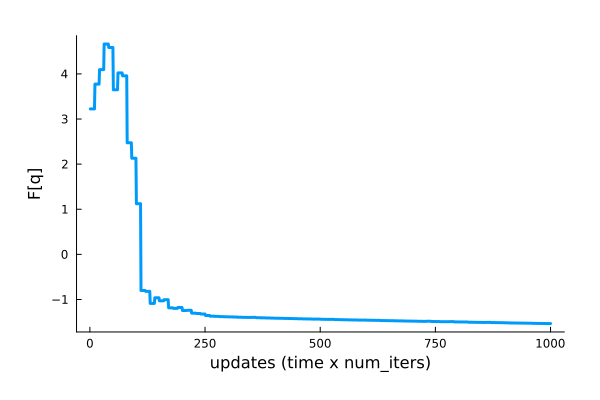

In [17]:
plot(FE_EFE[:], xlabel="updates (time x num_iters)", ylabel="F[q]")

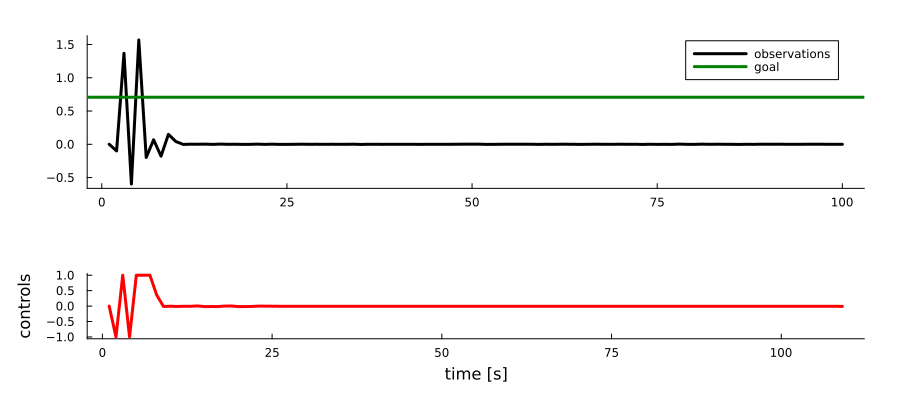

In [18]:
p1 = plot(y_EFE, color="black", label="observations")
hline!([mean(goal)], color="green", label="goal")
p4 = plot(u_EFE[1:end-1], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [19]:
savefig("figures/NARX-EFE-verification-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/NARX-EFE-verification-trial.png"

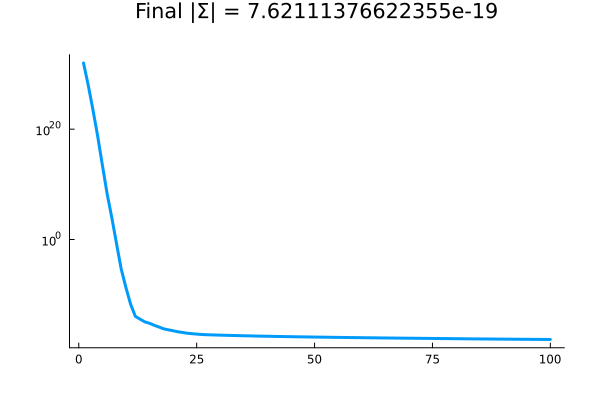

In [20]:
dSθ_EFE = [det(cov(pθ_EFE[k])) for k in 1:N]
final_dSθ_EFE = dSθ_EFE[end]
plot(dSθ_EFE, title="Final |Σ| = $final_dSθ_EFE", yscale=:log10)

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/NARX-EFE-verification-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/NARX-EFE-verification-planning.gif")
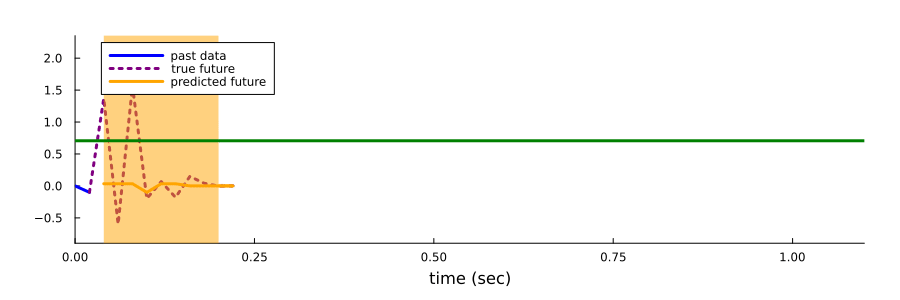

In [21]:
limsb = [minimum(y_EFE)*1.5, maximum(y_EFE)*1.5]

window = 20

anim = @animate for k in 2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_EFE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], py_EFE[k][1], ribbon=py_EFE[k][2], label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goals[1])], color="green")
    else
        plot(tsteps[k-window:k], y_EFE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], py_EFE[k][1], ribbon=py_EFE[k][2], label="prediction", color="orange", legend=:topleft)
        hline!([mean(goals[1])], color="green")
    end
    
end
gif(anim, "figures/NARX-EFE-verification-planning.gif", fps=24)

### Mean Squared Error minimization

In [22]:
# Start system
system = NARXsys(sys_coefficients, 
                 sys_basis,
                 sys_mnoise_sd, 
                 order_outputs=M_out, 
                 order_inputs=M_in,
                 input_lims=input_lims)

# Start agent
agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  thorizon=T)

# Preallocate
y_MSE = zeros(N)
u_MSE = zeros(N+T)
pτ_MSE = [pτ0]
pθ_MSE = [pθ0]
py_MSE = []
FE_MSE = zeros(num_iters, N)

@showprogress for k in 1:N
    
    # Act upon environment
    NARXsystem.update!(system, u_MSE[k])
    y_MSE[k] = system.observation
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_MSE[k], u_MSE[k])
    
    FE_MSE[:,k] = agent.free_energy
    push!(pθ_MSE, agent.qθ)
    push!(pτ_MSE, agent.qτ)
    
    # Optimal control
    policy = minimizeMSE(agent, [goal for t in 1:T], time_limit=tlimit, control_lims=u_lims)
    u_MSE[k+1] = policy[1]
    
    # Store future predictions
    push!(py_MSE, predictions(agent, policy, time_horizon=T))
    
end

Progress:   2%|▉                                        |  ETA: 0:01:26

Progress:   5%|██                                       |  ETA: 0:00:37

Progress:   8%|███▎                                     |  ETA: 0:00:24

Progress:  14%|█████▊                                   |  ETA: 0:00:14

Progress:  18%|███████▍                                 |  ETA: 0:00:11

Progress:  22%|█████████                                |  ETA: 0:00:09

Progress:  26%|██████████▋                              |  ETA: 0:00:07

Progress:  30%|████████████▎                            |  ETA: 0:00:06

Progress:  33%|█████████████▌                           |  ETA: 0:00:06

Progress:  36%|██████████████▊                          |  ETA: 0:00:05

Progress:  39%|████████████████                         |  ETA: 0:00:05

Progress:  43%|█████████████████▋                       |  ETA: 0:00:04

Progress:  46%|██████████████████▉                      |  ETA: 0:00:04

Progress:  50%|████████████████████▌                    |  ETA: 0:00:03

Progress:  53%|█████████████████████▊                   |  ETA: 0:00:03

Progress:  57%|███████████████████████▍                 |  ETA: 0:00:03

Progress:  61%|█████████████████████████                |  ETA: 0:00:02

Progress:  65%|██████████████████████████▋              |  ETA: 0:00:02

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:02

Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:02

Progress:  77%|███████████████████████████████▋         |  ETA: 0:00:01

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:01

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:01

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:01

Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


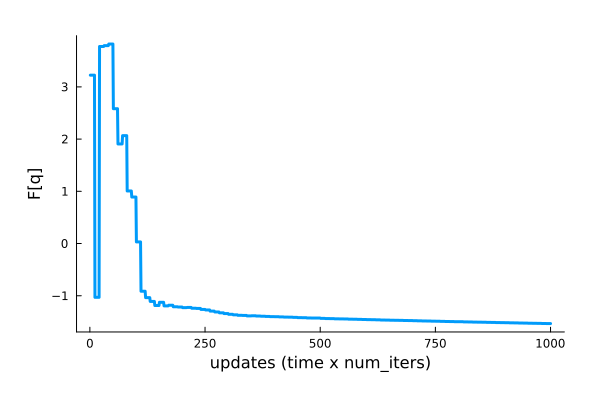

In [23]:
plot(FE_MSE[:], xlabel="updates (time x num_iters)", ylabel="F[q]")

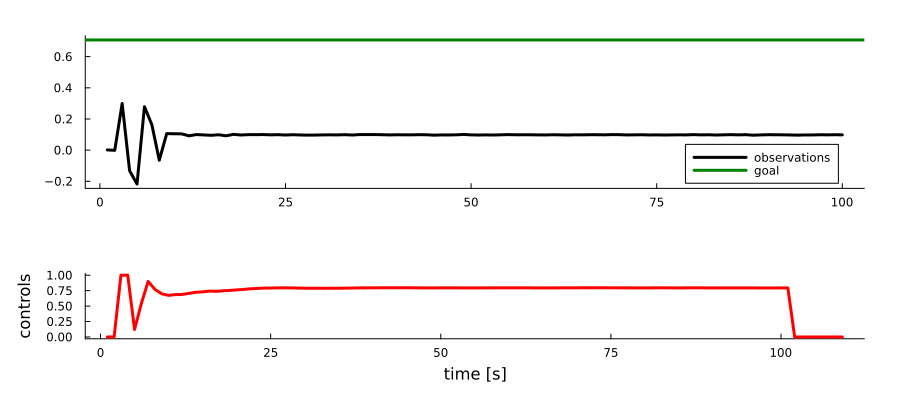

In [24]:
p1 = plot(y_MSE, color="black", label="observations")
hline!([mean(goal)], color="green", label="goal")
p4 = plot(u_MSE[1:end-1], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [25]:
savefig("figures/NARX-MSE-verification-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/NARX-MSE-verification-trial.png"

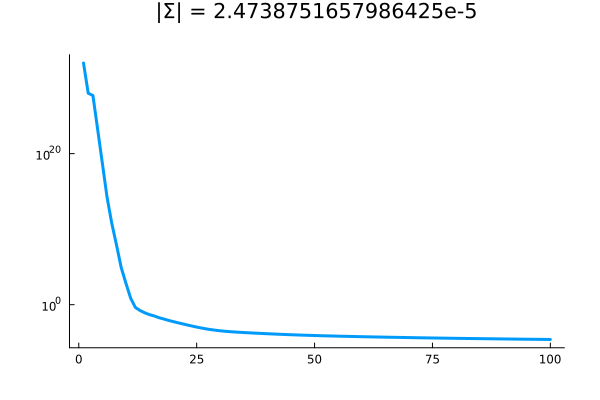

In [26]:
dSθ_MSE = [det(cov(pθ_MSE[k])) for k in 1:N]
final_dSθ_MSE = dSθ_MSE[end]
plot(dSθ_MSE, title="|Σ| = $final_dSθ_MSE", yscale=:log10)

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/NARX-MSE-verification-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/NARX-MSE-verification-planning.gif")
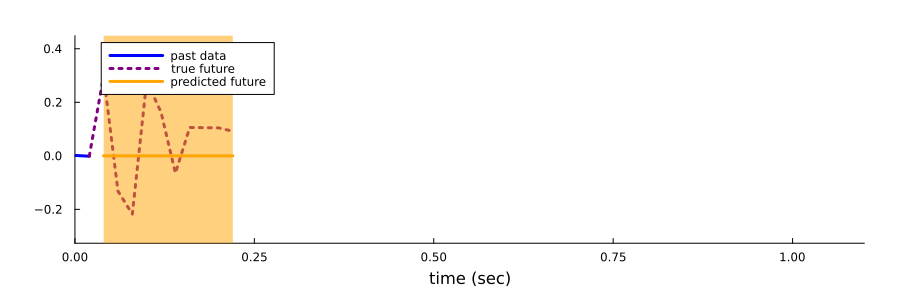

In [27]:
limsb = [minimum(y_MSE)*1.5, maximum(y_MSE)*1.5]
window = 20

anim = @animate for k in 2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_MSE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], py_MSE[k][1], ribbon=py_MSE[k][2], label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    else
        plot(tsteps[k-window:k], y_MSE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], py_MSE[k][1], ribbon=py_MSE[k][2], label="prediction", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    end
    
end
gif(anim, "figures/NARX-MSE-verification-planning.gif", fps=24)

### Comparison

In [28]:
println("Final |Σ| MSE = $final_dSθ_MSE")
println("Final |Σ| EFE = $final_dSθ_EFE")

Final |Σ| MSE = 2.4738751657986425e-5
Final |Σ| EFE = 7.62111376622355e-19


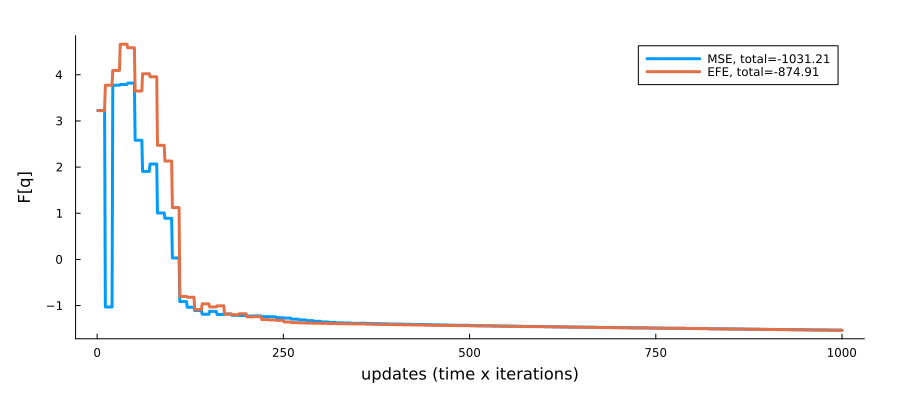

In [29]:
sF_MSE = round(sum(FE_MSE[:]), digits=2)
sF_EFE = round(sum(FE_EFE[:]), digits=2)

plot(xlabel="updates (time x iterations)", ylabel="F[q]", size=(900,400))
plot!(FE_MSE[:], label="MSE, total=$sF_MSE")
plot!(FE_EFE[:], label="EFE, total=$sF_EFE")

In [30]:
evidence_MSE = [-logpdf(py_MSE[k][1], y_MSE[k+1]) for k in 1:(N-1)]
evidence_EFE = [-logpdf(py_EFE[k][1], y_EFE[k+1]) for k in 1:(N-1)]

total_evidence_MSE = round(sum(evidence_MSE), digits=2)
total_evidence_EFE = round(sum(evidence_EFE), digits=2)

plot(xlabel="time (steps)", ylabel="-logp(y)", size=(900,400))
plot!(evidence_MSE, label="MSE, total=$total_evidence_MSE")
plot!(evidence_EFE, label="EFE, total=$total_evidence_EFE")

MethodError: MethodError: no method matching logpdf(::Vector{Float64}, ::Float64)

Closest candidates are:
  logpdf(!Matched::Poisson, ::Real)
   @ Distributions ~/.julia/packages/Distributions/GrN7f/src/univariates.jl:634
  logpdf(!Matched::BernoulliLogit, ::Real)
   @ Distributions ~/.julia/packages/Distributions/GrN7f/src/univariate/discrete/bernoullilogit.jl:75
  logpdf(!Matched::Distributions.Censored, ::Real)
   @ Distributions ~/.julia/packages/Distributions/GrN7f/src/censored.jl:329
  ...


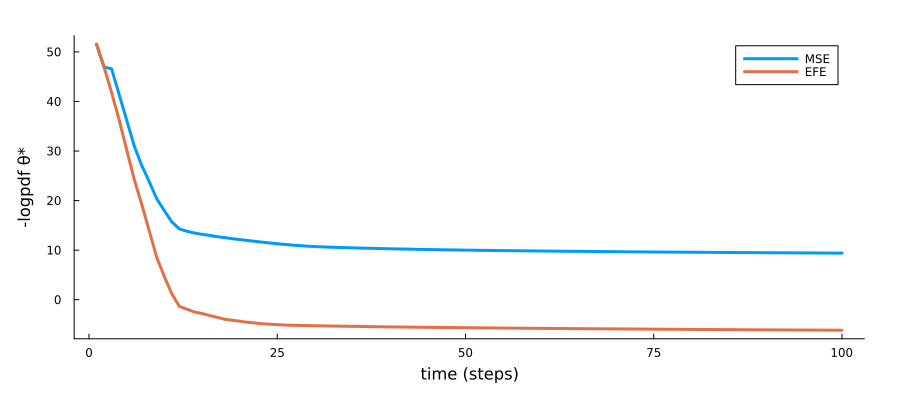

In [31]:
idθ_MSE = [-logpdf(pθ_MSE[k], sys_coefficients) for k in 1:N]
idθ_EFE = [-logpdf(pθ_EFE[k], sys_coefficients) for k in 1:N]

plot(xlabel="time (steps)", ylabel="-logpdf θ*", size=(900,400))
plot!(idθ_MSE, label="MSE")
plot!(idθ_EFE, label="EFE")

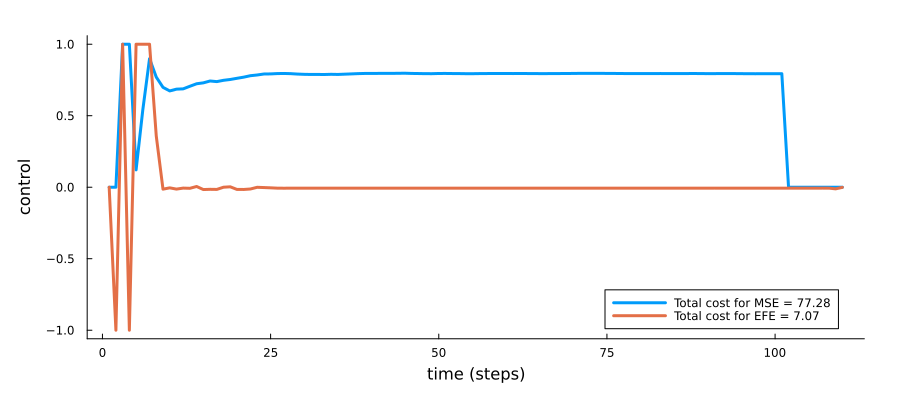

In [32]:
CC_MSE = round(sum(abs.(u_MSE)), digits=2)
CC_EFE = round(sum(abs.(u_EFE)), digits=2)

plot(xlabel="time (steps)", ylabel="control", size=(900,400))
plot!(u_MSE, label="Total cost for MSE = $CC_MSE")
plot!(u_EFE, label="Total cost for EFE = $CC_EFE")

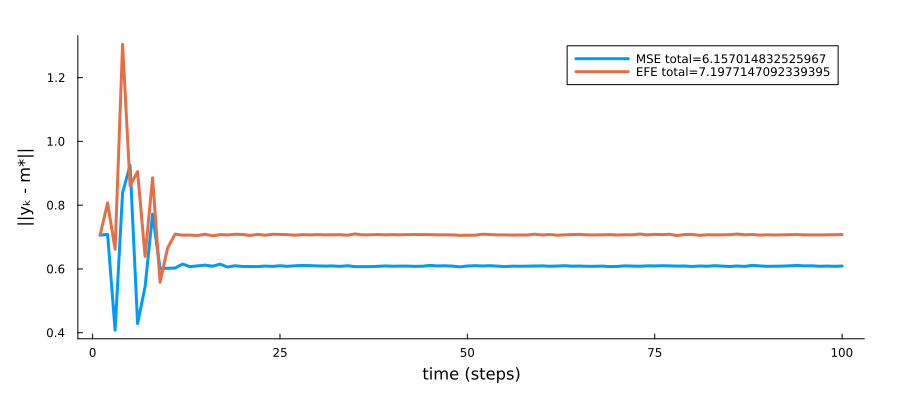

In [33]:
J_MSE = [norm(y_MSE[k] - mean(goal),2) for k in 1:N]
J_EFE = [norm(y_EFE[k] - mean(goal),2) for k in 1:N]

sJ_MSE = norm(y_MSE .- mean(goal),2)
sJ_EFE = norm(y_EFE .- mean(goal),2)

plot(xlabel="time (steps)", ylabel="||yₖ - m*||", size=(900,400))
plot!(J_MSE, label="MSE total=$sJ_MSE")
plot!(J_EFE, label="EFE total=$sJ_EFE")